In [18]:
# by Edilson Borba, tks André Ivaniski Mello for all support
# borba.edi@gmail.com

In [19]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.signal import hilbert
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
from scipy.signal import butter, lfilter
import ipywidgets as widgets
import math
import scipy.io
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from scipy.integrate import trapz
from scipy import signal
from scipy import stats
from openpyxl.styles import PatternFill

# FUNCTIONS DEFINITIONS

# BAND PASS BUTTERWORTH FILTER
def butter_bandpass(lowcut, highcut, fs, order):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# LOW PASS BUTTERWORTH FILTER
def butter_lowpass_filter(data,fc,fs,order):
    w = fc / (fs / 2) # Normalize the frequency
    b, a = signal.butter(order, w, 'low')
    output = signal.filtfilt(b, a, data)
    return output

# Normalize curve in 0-100% time points (interpolatation)
def interpolate_curve_to_100_points(Time, y, points):
    # Interpolate the curve to n points
    new_x = np.linspace(min(Time), max(Time), num=points)
    y_interp = np.interp(new_x, Time, y)
    return y_interp

In [20]:
# INPUT INFORMATIONS

Name = 'name'
Trial = '3km' # Nome do teste ou identificação
Walking_Speed_km = 3.0 # velocidade da esteira em quilometros por hora
Group = '1' # 1 Sedentario / 2 Ativo
Numero_Passadas = 10 # Determinar o número de passadas a serem selecionadas

File_Output = "/Users/borba/Desktop/" #salvar todos os docs na mesma pasta

# Caminho do arquivo .trc de MARCADORES (Marker Data)
File_Path_Marker = "/Users/Desktop/"
File_Name_Marker = "arquivo.trc"

File_Output_Name_Marker = f"{Name}_kmh_{Trial}_MARKER.xlsx"

# Caminho do arquivo .sto de ANGULOS (Kinematics_q)
File_Path_Angles = "/Users/Desktop/"
File_Name_Angles = "arquivo_Kinematics_q.sto"

File_Output_Name_Angles = f"{Name}_kmh_{Trial}_ANGLES.xlsx"

# Atribuindo grupo, não modificar
if Group == '1':
    Group = 'Sedentário'
elif Group == '2':
    Group = 'Ativo'
else:
    Group = 'Desconhecido'

In [21]:
# Leitura do arquivo .sto e conversão para DataFrame pandas
with open(File_Path_Marker + File_Name_Marker, 'r') as file:
    linhas = file.readlines()[6:]

Dados_Excel = []
for linha in linhas:
    Dados_Linha = linha.strip().split()  
    Dados_Excel.append(Dados_Linha)

# Criar DataFrame pandas e salvar como arquivo .xlsx
df = pd.DataFrame(Dados_Excel)
df.to_excel((File_Output + File_Output_Name_Marker), index=False)
File_Output_Path_Full_Marker = File_Output + File_Output_Name_Marker
data_marker = pd.read_excel(File_Output_Path_Full_Marker, skiprows=0)

selected_columns = list(data_marker.columns[:6]) 
print(data_marker[selected_columns].head(5))

# A coluna 0 (Zero) é o frame e a coluna 1 (Um) é o tempo em segundos

   0         1        2        3        4        5
0  1  0.000000 -0.14227  1.38080 -0.06550 -0.15461
1  2  0.016667 -0.14425  1.38343 -0.06350 -0.15628
2  3  0.033333 -0.14611  1.38603 -0.06180 -0.15750
3  4  0.050000 -0.14745  1.38847 -0.06027 -0.15831
4  5  0.066667 -0.14807  1.39043 -0.05872 -0.15883


In [22]:
# Leitura do arquivo .sto e conversão para DataFrame pandas
with open(File_Path_Angles + File_Name_Angles, 'r') as file:
    linhas = file.readlines()[11:]

Dados_Excel = []
for linha in linhas:
    Dados_Linha = linha.strip().split()  
    Dados_Excel.append(Dados_Linha)

# Criar DataFrame pandas e salvar como arquivo .xlsx
df = pd.DataFrame(Dados_Excel)
df.to_excel((File_Output + File_Output_Name_Angles), index=False)
File_Output_Path_Full_Angles = File_Output + File_Output_Name_Angles
data_angles = pd.read_excel(File_Output_Path_Full_Angles, skiprows=0)

selected_columns = list(data_angles.columns[:5]) 
print(data_angles[selected_columns].head(5))

# A coluna 0 (Zero) é o tempo em segundos

          0         1         2           3         4
0  0.000000  0.176311  3.490729  177.859168 -0.176819
1  0.016667  0.808860  4.626160  177.901154 -0.181567
2  0.033333  0.190637  4.255131  178.327373 -0.184092
3  0.050000 -0.054057  3.605808  178.883335 -0.183189
4  0.066667 -0.166781  3.343047  179.407874 -0.182551


In [23]:
Data_Marker = np.array(data_marker) #Marcadores 
Data_Angle = np.array(data_angles) #Angulares 

Time = Data_Marker[:,1]
Frame = Data_Marker[:,0]
fsample = 1 / (Time[2] - Time[1])
print("Frequência de amostragem:", round(fsample), "Hz")

dt_Kinematic = 1/fsample

# Recort File here if needed

# Excluir as primeiras 120 linhas
# Data_Marker = Data_Marker[1200:, :]
# Data_Angle = Data_Angle[1200:, :]

# Excluir as últimas 120 linhas
# Data_Marker = Data_Marker[-120:, :]
# Data_Angle = Data_Angle[-120:, :]

# Selecionar da linha 120 até a linha 700
# Data_Marker = Data_Marker[120:700]
# Data_Angle = Data_Angle[120:700]

# X: AP
# Y: Vertical
# Z: ML

# LOW PASS FILTER
cutoff = 6
order = 3

filtered_data_marker = np.zeros_like(Data_Marker)
for col in range(Data_Marker.shape[1]):
    filtered_data_marker[:, col] =  butter_lowpass_filter(Data_Marker[:, col], cutoff, fsample, order)

Data_Marker = filtered_data_marker

filtered_data_angle = np.zeros_like(Data_Angle)
for col in range(Data_Angle.shape[1]):
    filtered_data_angle[:, col] =  butter_lowpass_filter(Data_Angle[:, col], cutoff, fsample, order)

Data_Angle = filtered_data_angle

# Data Angles

R_Hip_Flexion = Data_Angle[:,7]
R_Knee_Flexion = Data_Angle[:,10]
R_Ankle_Flexion = Data_Angle[:,12]

L_Hip_Flexion = Data_Angle[:,15]
L_Knee_Flexion = Data_Angle[:,18]
L_Ankle_Flexion = Data_Angle[:,20]

Pelvis_Rotation = Data_Angle[:,3]
Lumbar_Rotation = Data_Angle[:,25]
# Subtraindo 180 de todas as linhas
Pelvis_Rotation[Pelvis_Rotation > 50] -= 180
Pelvis_Rotation[Pelvis_Rotation < -50] += 180
# Lumbar_Rotation -= 180

# Data Markers

Neck_X = Data_Marker[:,2]
Neck_Y = Data_Marker[:,3]
Neck_Z = Data_Marker[:,4]

C7_X = Data_Marker[:,122]
C7_Y = Data_Marker[:,123]
C7_Z = Data_Marker[:,124]

Shoulder_Right_X = Data_Marker[:,116]
Shoulder_Right_Y = Data_Marker[:,117]
Shoulder_Right_Z = Data_Marker[:,118]
Shoulder_Left_X = Data_Marker[:,119]
Shoulder_Left_Y = Data_Marker[:,120]
Shoulder_Left_Z = Data_Marker[:,121]

Elbow_Right_X = Data_Marker[:,7]
Elbow_Right_Y = Data_Marker[:,8]
Elbow_Right_Z = Data_Marker[:,9]
Elbow_Left_X = Data_Marker[:,17]
Elbow_Left_Y = Data_Marker[:,18]
Elbow_Left_Z = Data_Marker[:,19]

Wrist_Right_X = Data_Marker[:,11]
Wrist_Right_Y = Data_Marker[:,12]
Wrist_Right_Z = Data_Marker[:,13]
Wrist_Left_X = Data_Marker[:,20]
Wrist_Left_Y = Data_Marker[:,21]
Wrist_Left_Z = Data_Marker[:,22]

Midhip_X = Data_Marker[:,23] #MidHip = mean hip right and hip left 
Midhip_Y = Data_Marker[:,24]
Midhip_Z = Data_Marker[:,25]

R_Shoulder_X = Data_Marker[:,5]
R_Shoulder_Y = Data_Marker[:,6]
R_Shoulder_Z = Data_Marker[:,7]
R_Elbow_X = Data_Marker[:,8]
R_Elbow_Y = Data_Marker[:,9]
R_Elbow_Z = Data_Marker[:,10]
R_Wrist_X = Data_Marker[:,11]
R_Wrist_Y = Data_Marker[:,12]
R_Wrist_Z = Data_Marker[:,13]

L_Shoulder_X = Data_Marker[:,14]
L_Shoulder_Y = Data_Marker[:,15]
L_Shoulder_Z = Data_Marker[:,16]
L_Elbow_X = Data_Marker[:,17]
L_Elbow_Y = Data_Marker[:,18]
L_Elbow_Z = Data_Marker[:,19]
L_Wrist_X = Data_Marker[:,20]
L_Wrist_Y = Data_Marker[:,21]
L_Wrist_Z = Data_Marker[:,22]

R_Hip_X = Data_Marker[:,26]
R_Hip_Y = Data_Marker[:,27]
R_Hip_Z = Data_Marker[:,28]
R_Knee_X = Data_Marker[:,29]
R_Knee_Y = Data_Marker[:,30]
R_Knee_Z = Data_Marker[:,31]
R_Ankle_X = Data_Marker[:,32]
R_Ankle_Y = Data_Marker[:,33]
R_Ankle_Z = Data_Marker[:,34]

L_Hip_X = Data_Marker[:,35]
L_Hip_Y = Data_Marker[:,36]
L_Hip_Z = Data_Marker[:,37]
L_Knee_X = Data_Marker[:,38]
L_Knee_Y = Data_Marker[:,39]
L_Knee_Z = Data_Marker[:,40]
L_Ankle_X = Data_Marker[:,41]
L_Ankle_Y = Data_Marker[:,42]
L_Ankle_Z = Data_Marker[:,43]

L_Toe_X = Data_Marker[:,47] #Small Toe
L_Toe_Y = Data_Marker[:,48]
L_Toe_Z = Data_Marker[:,49]
L_Heel_X = Data_Marker[:,50]
L_Heel_Y = Data_Marker[:,51]
L_Heel_Z = Data_Marker[:,52]

R_Toe_X = Data_Marker[:,56]
R_Toe_Y = Data_Marker[:,57]
R_Toe_Z = Data_Marker[:,58]
R_Heel_X = Data_Marker[:,59]
R_Heel_Y = Data_Marker[:,60]
R_Heel_Z = Data_Marker[:,61]

R_PSIS_X = Data_Marker[:,68]
R_PSIS_Y = Data_Marker[:,69]
R_PSIS_Z = Data_Marker[:,70]

L_PSIS_X = Data_Marker[:,71]
L_PSIS_Y = Data_Marker[:,72]
L_PSIS_Z = Data_Marker[:,73]

R_Asis_X = Data_Marker[:,62]
R_Asis_Y = Data_Marker[:,63]
R_Asis_Z = Data_Marker[:,64]

L_Asis_X = Data_Marker[:,65]
L_Asis_Y = Data_Marker[:,66]
L_Asis_Z = Data_Marker[:,67]

Midhip_X = Data_Marker[:,23]
Midhip_Y = Data_Marker[:,24]
Midhip_Z = Data_Marker[:,25]

Sacrum_X = np.mean([R_PSIS_X, L_PSIS_X], axis=0)


Frequência de amostragem: 60 Hz


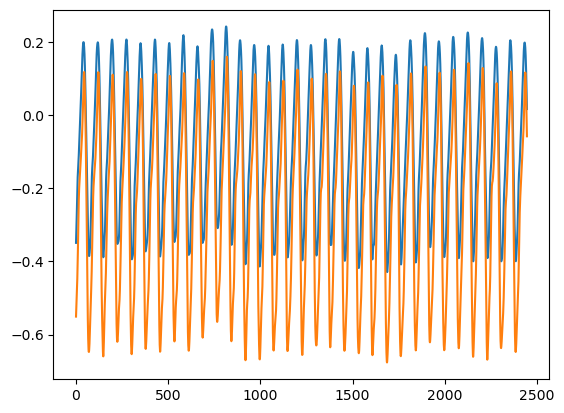

In [24]:
# X: AP
# Y: Vertical
# Z: ML
plt.plot(L_Heel_X)
plt.plot(L_Toe_X)

In [25]:
# KINEMATIC TOUCH-DOWN (TD) AND TAKE-OFF (TO) EVENTS DETERMINATION
# Zeni et al. 2008 (doi:10.1016/j.gaitpost.2007.07.007) method:

# TD: max(Heel_x - Sacrum_x)
# TO: min(Toe_x - Sacrum_x)

# X: AP
# Y: Vertical
# Z: ML

R_HeelSacrum = R_Heel_X - Sacrum_X
R_ToeSacrum = R_Toe_X - Sacrum_X

L_HeelSacrum = L_Heel_X - Sacrum_X
L_ToeSacrum = L_Toe_X - Sacrum_X

cutoff = 6
order = 3

# Low Pass Butterworth filter stronger
R_HeelSacrum = butter_lowpass_filter(R_HeelSacrum, cutoff, fsample, order)
R_ToeSacrum= butter_lowpass_filter(R_HeelSacrum, cutoff, fsample, order)
L_HeelSacrum = butter_lowpass_filter(L_HeelSacrum, cutoff, fsample, order)
L_ToeSacrum= butter_lowpass_filter(L_HeelSacrum, cutoff, fsample, order)

# TD: max(Heel_x - Sacrum_x)
# TO: min(Toe_x - Sacrum_x)
TD_R, _ = find_peaks(-R_HeelSacrum, distance=30) #distance between peaks of at least 50 frames
TO_R,_ = find_peaks(R_ToeSacrum, distance=30) #distance between peaks of at least 50 frames
TD_R = TD_R.flatten()
TO_R = TO_R.flatten()
# Delete the First TO value if is lower than the First TD value (to start with TD always: TD1-TO-TD2)
if TO_R[0] < TD_R[0]:
    TO_R = TO_R[1:]

TD_L, _ = find_peaks(-L_HeelSacrum, distance=30) #distance between peaks of at least 50 frames
TO_L,_ = find_peaks(L_ToeSacrum, distance=30) #distance between peaks of at least 50 frames
TD_L = TD_L.flatten()
TO_L = TO_L.flatten()
# Delete the First TO value if is lower than the First TD value (to start with TD always: TD1-TO-TD2)
if TO_L[0] < TD_L[0]:
    TO_L = TO_L[1:]
    
if TD_L[0] < TD_R[0]:
    TD_L = TD_L[1:]
    TO_L = TO_L[1:]

# Manual TD TO se precisar
# TD_R = TD_R[1:]
# TO_R = TO_R[1:]
# TD_L = TD_L[1:]
# TO_L = TO_L[1:]

print('TD R',TD_R)
print('TO R', TO_R)
print('TD L',TD_L)
print('TO L', TO_L)

# Criando os arrays Td_R, Td_L, To_R, To_L a partir dos arrays originais
Td_R = np.array(TD_R)
Td_L = np.array(TD_L)
To_R = np.array(TO_R)
To_L = np.array(TO_L)

# Encontrando o número mínimo de linhas entre TD_R, TD_L, TO_R e TO_L
num_rows = min(len(Td_R), len(Td_L), len(To_R), len(To_L))

# Selecionando apenas os primeiros num_rows elementos de cada array
Td_R = Td_R[:num_rows]
Td_L = Td_L[:num_rows]
To_R = To_R[:num_rows]
To_L = To_L[:num_rows]

# Criando listas vazias para armazenar os valores intercalados
intercalated_TD = []
intercalated_TO = []
Leg = []

# Iterando pelas linhas e intercalando os valores das pernas direita e esquerda
for i in range(num_rows):
    intercalated_TD.extend([Td_R[i], Td_L[i]])
    intercalated_TO.extend([To_R[i], To_L[i]])
    Leg.extend(['Right', 'Left'])

# Criando o DataFrame com os dados intercalados
data = {'Leg': Leg, 'TD': intercalated_TD, 'TO': intercalated_TO, }
df = pd.DataFrame(data)

# Adicionando uma coluna numerada ao DataFrame
df.insert(0, 'Step', range(1, len(df) + 1))

# Salvando o DataFrame em um arquivo Excel
caminho = File_Output  
nome_arquivo = f"TD_TO_{Name}_{Trial}.xlsx"
caminho_completo = caminho + nome_arquivo  
df.to_excel(caminho_completo, index=False)  
print(f"Dados exportados para '{nome_arquivo}' com sucesso.")

Strides_Number_R = len(TD_R) #Number of strides
Strides_Number_L = len(TD_L) #Number of strides

TD R [  29  106  184  262  340  418  495  571  648  726  804  879  955 1033
 1110 1189 1264 1341 1418 1492 1573 1647 1725 1802 1882 1960 2036 2115
 2192 2267 2346 2422]
TO R [  80  158  235  312  391  469  545  620  699  778  853  929 1007 1084
 1160 1237 1315 1390 1467 1544 1620 1697 1774 1853 1931 2009 2087 2164
 2241 2317 2395]
TD L [  71  148  225  302  379  456  534  611  688  767  844  919  996 1073
 1148 1228 1304 1381 1458 1533 1608 1688 1763 1844 1921 1998 2077 2155
 2233 2307 2386]
TO L [ 119  196  274  351  429  506  584  660  739  816  891  968 1045 1122
 1199 1275 1353 1429 1504 1582 1659 1735 1814 1893 1969 2048 2126 2203
 2279 2357 2434]
Dados exportados para 'TD_TO_Iasbella_3km.xlsx' com sucesso.


In [26]:
# Selecionar os eventos de TD e TO das primeiras 10 passadas para o pé direito
TD_R = TD_R[:Numero_Passadas]
TO_R = TO_R[:Numero_Passadas]

# Selecionar os eventos de TD e TO das primeiras 10 passadas para o pé esquerdo
TD_L = TD_L[:Numero_Passadas]
TO_L = TO_L[:Numero_Passadas]

print(TD_R)
print(TD_L)
print(TO_R)
print(TO_L)

[ 29 106 184 262 340 418 495 571 648 726]
[ 71 148 225 302 379 456 534 611 688 767]
[ 80 158 235 312 391 469 545 620 699 778]
[119 196 274 351 429 506 584 660 739 816]


(0.0, 80.0)

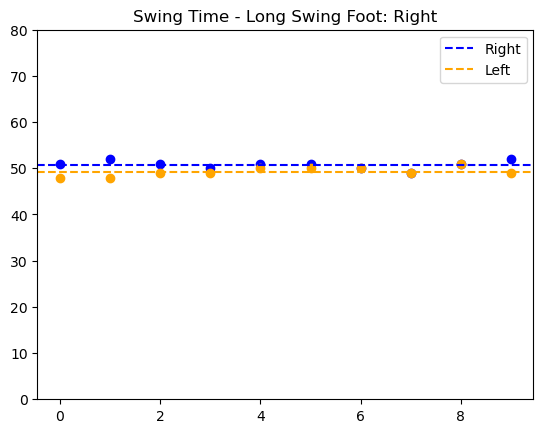

In [27]:
# SWING TIME OF EACH FOOT
#Always start with TD
Swing_Time_R = []

for i in range(len(TO_R)):
    Swing_Iteration = TO_R[i] - TD_R[i]
    Swing_Time_R.append(Swing_Iteration)

Swing_Time_L = []
for i in range(len(TO_L)):
    Swing_Iteration = TO_L[i] - TD_L[i]
    Swing_Time_L.append(Swing_Iteration)

# Determine the Reference foot for PCI.
# The Reference foot is the foot with the greatee mean swing time
Swing_Time_R_mean = np.mean(Swing_Time_R)
Swing_Time_L_mean = np.mean(Swing_Time_L)

if Swing_Time_R_mean > Swing_Time_L_mean:
    Foot_LongSwing = 'Right'
else:
    Foot_LongSwing = 'Left'
    
plt.title(f'Swing Time - Long Swing Foot: {Foot_LongSwing}')
plt.scatter(np.arange(len(Swing_Time_R)), Swing_Time_R, color='blue')
plt.axhline(y=Swing_Time_R_mean, color='blue', linestyle='--', label='Right')
plt.scatter(np.arange(len(Swing_Time_L)), Swing_Time_L, color='orange')
plt.axhline(y=Swing_Time_L_mean, color='orange', linestyle='--', label='Left')
plt.legend()
plt.ylim(0,80)

[ 29 106 184 262 340 418 495 571 648 726]
[ 71 148 225 302 379 456 534 611 688 767]
-----------
[ 29 106 184 262 340 418 495 571 648 726]
[ 80 158 235 312 391 469 545 620 699 778]
[ 71 148 225 302 379 456 534 611 688 767]
Accuracy 3.585400953822007
COV 3.041939676439757
PCI 6.627340630261764


Text(0.5, 0, 'Gait cycle (n)')

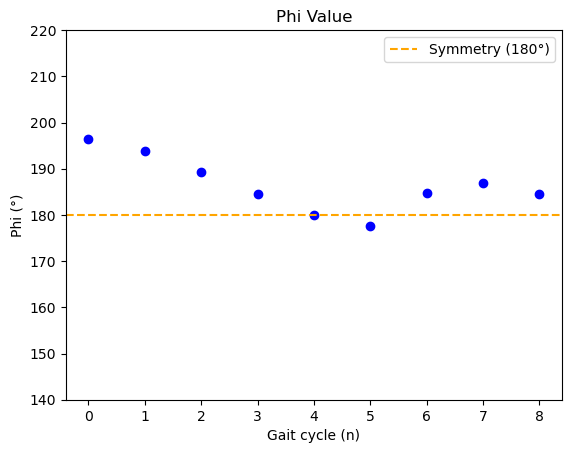

In [28]:
# REFERENCE FOOT VERIFICATION AND TD ARRAYS ADJUSTMENTS

if (Foot_LongSwing == 'Right') and (TD_L[0] < TD_R[0]): # Reference foot is Right, but the file starts with Left TD
    TD_L_new = TD_L[1:] # Delete the first TD from Left foot to adjust
    TD_R_new = TD_R
    TD_Long = TD_R_new
    TD_Short = TD_L_new
    TO_Long = TO_R
elif (Foot_LongSwing == 'Right') and (TD_L[0] > TD_R[0]): # Reference foot is Right, and the file starts with Right TD
    TD_L_new = TD_L
    TD_R_new = TD_R
    TD_Long = TD_R_new
    TD_Short = TD_L_new
    TO_Long = TO_R
elif (Foot_LongSwing == 'Left') and (TD_L[0] > TD_R[0]): # Reference foot is Left, but the file starts with Right TD
    TD_L_new = TD_L
    TD_R_new = TD_R[1:]
    TD_Long = TD_L_new
    TD_Short = TD_R_new
    TO_Long = TO_L
elif (Foot_LongSwing == 'Left') and (TD_L[0] < TD_R[0]): # Reference foot is Left, and the file starts with Left TD
    TD_L_new = TD_L
    TD_R_new = TD_R
    TD_Long = TD_L_new
    TD_Short = TD_R_new
    TO_Long = TO_L

print((TD_R))
print((TD_L))
print('-----------')
print(TD_R_new)
print(TO_R)
print(TD_L_new)

# PHI CALCULATION
#Phi = (TD_1_short -TD_1_long) / (TD_2_long - TD_1_long) * 360
Phi_Array = []
for m in range(1,len(TD_Long)): #it will run from iteration {1} until {len(TD_Long)-1}
    Phi_Iteration = (TD_Short[m-1] - TD_Long[m-1]) / (TD_Long[m] - TD_Long[m-1]) * 360
    Phi_Array.append(Phi_Iteration)

Phi_Mean = np.mean(Phi_Array)
Phi_SD = np.std(Phi_Array)

Accuracy_Phi = abs(Phi_Mean-180)/180 * 100
COV_Phi = Phi_SD/Phi_Mean *100

PCI = Accuracy_Phi + COV_Phi

print('Accuracy', Accuracy_Phi)
print('COV', COV_Phi)
print('PCI', PCI)

plt.title('Phi Value')
plt.scatter(np.arange(len(Phi_Array)), Phi_Array, color='blue')
plt.axhline(y=180, color='orange', linestyle='--', label='Symmetry (180°)')
plt.legend()
plt.ylim(140,220)
plt.ylabel('Phi (°)')
plt.xlabel('Gait cycle (n)')

In [29]:
# SPATIOTEMPORAL
Speed = Walking_Speed_km / 3.6
Stride_Time = []
Contact_Time = []
Contact_Phase = []
Stride_Length = []
Stride_Frequency = []
Step_Swing = []


for m in range(1,len(TD_Long)): #it will run from iteration {1} until {len(TD_Long)-1}
    Stride_Time_Iteration = (TD_Long[m] - TD_Long[m-1]) / fsample
    Contact_Time_Iteration = (TO_Long[m-1] - TD_Long[m-1]) * (1 / fsample)
    Contact_Phase_Iteration = (TO_Long[m-1] - TD_Long[m-1]) / (TD_Long[m] - TD_Long[m-1]) * 100
    Stride_Length_Iteration = Speed * Stride_Time_Iteration
    Stride_Frequency_Iteration = 1 / Stride_Time_Iteration
    Step_Swing_Iteration = (TD_Long[m] - TO_Long[m-1]) * dt_Kinematic
    
    Stride_Time.append(Stride_Time_Iteration)
    Contact_Time.append(Contact_Time_Iteration)
    Contact_Phase.append(Contact_Phase_Iteration)
    Stride_Length.append(Stride_Length_Iteration)
    Stride_Frequency.append(Stride_Frequency_Iteration)
    Step_Swing.append(Step_Swing_Iteration)

Stride_Time_Mean = np.mean(Stride_Time)
Contact_Time_Mean = np.mean(Contact_Time)
Contact_Phase_Mean = np.mean(Contact_Phase)
Stride_Length_Mean = np.mean(Stride_Length)
Stride_Frequency_Mean = np.mean(Stride_Frequency)
Step_Swing_Mean = np.mean(Step_Swing)
Speed = Speed

# fig, axs = plt.subplots(5)
# width = 12
# height = 8
# fig.set_size_inches(width,height)
# plt.subplots_adjust(hspace=0.5)  # Increase the vertical spacing
    
# axs[0].set_title('Stride Time (s)')
# axs[0].scatter(np.arange(len(Stride_Time)), Stride_Time)
# axs[0].set_ylim(0.6, 1.6)
# axs[1].set_title('Contact Time (s)')
# axs[1].scatter(np.arange(len(Contact_Time)), Contact_Time)
# axs[1].set_ylim(0.4,1.5)
# axs[2].set_title('Contact Phase (%)')
# axs[2].scatter(np.arange(len(Contact_Phase)), Contact_Phase)
# axs[2].set_ylim(40,80)
# axs[3].set_title('Stride Length (m)')
# axs[3].scatter(np.arange(len(Stride_Length)), Stride_Length)
# axs[3].set_ylim(0.2,2.0)
# axs[3].set_yticks(np.arange(0.2,2.0,0.4))
# axs[4].set_title('StrideFrequency (Hz)')
# axs[4].scatter(np.arange(len(Stride_Frequency)), Stride_Frequency)
# axs[4].set_ylim(0.5,1.5)
# axs[4].set_yticks(np.arange(0.5,1.5,0.2))

print("Stride Time Mean: {:.2f}".format(Stride_Time_Mean))
print("Contact Time Mean: {:.2f}".format(Contact_Time_Mean))
print("Contact Phase Mean: {:.2f}".format(Contact_Phase_Mean))
print("Stride Length Mean: {:.2f}".format(Stride_Length_Mean))
print("Stride Frequency Mean: {:.2f}".format(Stride_Frequency_Mean))
print("Step Swing Mean: {:.2f}".format(Step_Swing_Mean))
print("Speed (m/s): {:.2f}".format(Speed))


Stride Time Mean: 1.29
Contact Time Mean: 0.84
Contact Phase Mean: 65.42
Stride Length Mean: 1.08
Stride Frequency Mean: 0.77
Step Swing Mean: 0.45
Speed (m/s): 0.83


In [30]:
# Angle definition

R_Knee_Flexion_Max_All_Strides = []
R_Knee_Flexion_Min_All_Strides = []
R_Knee_Flexion_ROM_All_Strides = []
R_Hip_Flexion_Max_All_Strides = []
R_Hip_Flexion_Min_All_Strides = []
R_Hip_Flexion_ROM_All_Strides = []
R_Ankle_Flexion_Max_All_Strides = []
R_Ankle_Flexion_Min_All_Strides = []
R_Ankle_Flexion_ROM_All_Strides = []

Pelvis_Rotation_Max_All_Strides = []
Pelvis_Rotation_Min_All_Strides = []
Pelvis_Rotation_ROM_All_Strides = []
Lumbar_Rotation_Max_All_Strides = []
Lumbar_Rotation_Min_All_Strides = []
Lumbar_Rotation_ROM_All_Strides = []

for k in range(0,len(TD_R)-1):
    start = TD_R[k]
    end = TD_R[k+1]
    R_Knee_Flexion_Stride = R_Knee_Flexion[start:end]
    R_Knee_Flexion_Max = np.max(R_Knee_Flexion_Stride)
    R_Knee_Flexion_Min = np.min(R_Knee_Flexion_Stride)
    R_Knee_Flexion_ROM = R_Knee_Flexion_Max - R_Knee_Flexion_Min
    R_Knee_Flexion_Max_All_Strides.append(R_Knee_Flexion_Max)
    R_Knee_Flexion_Min_All_Strides.append(R_Knee_Flexion_Min)
    R_Knee_Flexion_ROM_All_Strides.append(R_Knee_Flexion_ROM)
    
    R_Hip_Flexion_Stride = R_Hip_Flexion[start:end]
    R_Hip_Flexion_Max = np.max(R_Hip_Flexion_Stride)
    R_Hip_Flexion_Min = np.min(R_Hip_Flexion_Stride)
    R_Hip_Flexion_ROM = R_Hip_Flexion_Max - R_Hip_Flexion_Min
    R_Hip_Flexion_Max_All_Strides.append(R_Hip_Flexion_Max)
    R_Hip_Flexion_Min_All_Strides.append(R_Hip_Flexion_Min)
    R_Hip_Flexion_ROM_All_Strides.append(R_Hip_Flexion_ROM)
    
    R_Ankle_Flexion_Stride = R_Ankle_Flexion[start:end]
    R_Ankle_Flexion_Max = np.max(R_Ankle_Flexion_Stride)
    R_Ankle_Flexion_Min = np.min(R_Ankle_Flexion_Stride)
    R_Ankle_Flexion_ROM = R_Ankle_Flexion_Max - R_Ankle_Flexion_Min
    R_Ankle_Flexion_Max_All_Strides.append(R_Ankle_Flexion_Max)
    R_Ankle_Flexion_Min_All_Strides.append(R_Ankle_Flexion_Min)
    R_Ankle_Flexion_ROM_All_Strides.append(R_Ankle_Flexion_ROM)
    
    # Cálculo da rotação da pelve
    Pelvis_Rotation_Stride = Pelvis_Rotation[start:end]
    Pelvis_Rotation_Max = np.max(Pelvis_Rotation_Stride)
    Pelvis_Rotation_Min = np.min(Pelvis_Rotation_Stride)
    Pelvis_Rotation_ROM = Pelvis_Rotation_Max - Pelvis_Rotation_Min
    Pelvis_Rotation_Max_All_Strides.append(Pelvis_Rotation_Max)
    Pelvis_Rotation_Min_All_Strides.append(Pelvis_Rotation_Min)
    Pelvis_Rotation_ROM_All_Strides.append(Pelvis_Rotation_ROM)
    
    # Encontrando índices de máximo e mínimo para a pelve
    Pelvis_Rotation_Max_Index = np.argmax(Pelvis_Rotation_Stride)
    Pelvis_Rotation_Min_Index = np.argmin(Pelvis_Rotation_Stride)
    
    # Calculando a rotação correspondente da lombar nos pontos de máximo e mínimo da pelve
    Lumbar_Rotation_Max = Lumbar_Rotation[start + Pelvis_Rotation_Max_Index]
    Lumbar_Rotation_Min = Lumbar_Rotation[start + Pelvis_Rotation_Min_Index]
    Lumbar_Rotation_ROM = Lumbar_Rotation_Max - Lumbar_Rotation_Min

    Lumbar_Rotation_Max_All_Strides.append(Lumbar_Rotation_Max)
    Lumbar_Rotation_Min_All_Strides.append(Lumbar_Rotation_Min)
    Lumbar_Rotation_ROM_All_Strides.append(Lumbar_Rotation_ROM)
    
    # Lumbar_Rotation_Stride = Lumbar_Rotation[start:end]
    # Lumbar_Rotation_Max = np.max(Lumbar_Rotation_Stride)
    # Lumbar_Rotation_Min = np.min(Lumbar_Rotation_Stride)
    # Lumbar_Rotation_ROM = Lumbar_Rotation_Max - Lumbar_Rotation_Min
    # Lumbar_Rotation_Max_All_Strides.append(Lumbar_Rotation_Max)
    # Lumbar_Rotation_Min_All_Strides.append(Lumbar_Rotation_Min)
    # Lumbar_Rotation_ROM_All_Strides.append(Lumbar_Rotation_ROM)
    
L_Knee_Flexion_Max_All_Strides = []
L_Knee_Flexion_Min_All_Strides = []
L_Knee_Flexion_ROM_All_Strides = []
L_Hip_Flexion_Max_All_Strides = []
L_Hip_Flexion_Min_All_Strides = []
L_Hip_Flexion_ROM_All_Strides = []
L_Ankle_Flexion_Max_All_Strides = []
L_Ankle_Flexion_Min_All_Strides = []
L_Ankle_Flexion_ROM_All_Strides = []

for k in range(0, len(TD_L) - 1):
    start = TD_L[k]
    end = TD_L[k + 1]
    L_Knee_Flexion_Stride = L_Knee_Flexion[start:end]
    L_Knee_Flexion_Max = np.max(L_Knee_Flexion_Stride)
    L_Knee_Flexion_Min = np.min(L_Knee_Flexion_Stride)
    L_Knee_Flexion_ROM = L_Knee_Flexion_Max - L_Knee_Flexion_Min
    L_Knee_Flexion_Max_All_Strides.append(L_Knee_Flexion_Max)
    L_Knee_Flexion_Min_All_Strides.append(L_Knee_Flexion_Min)
    L_Knee_Flexion_ROM_All_Strides.append(L_Knee_Flexion_ROM)
    
    L_Hip_Flexion_Stride = L_Hip_Flexion[start:end]
    L_Hip_Flexion_Max = np.max(L_Hip_Flexion_Stride)
    L_Hip_Flexion_Min = np.min(L_Hip_Flexion_Stride)
    L_Hip_Flexion_ROM = L_Hip_Flexion_Max - L_Hip_Flexion_Min
    L_Hip_Flexion_Max_All_Strides.append(L_Hip_Flexion_Max)
    L_Hip_Flexion_Min_All_Strides.append(L_Hip_Flexion_Min)
    L_Hip_Flexion_ROM_All_Strides.append(L_Hip_Flexion_ROM)
    
    L_Ankle_Flexion_Stride = L_Ankle_Flexion[start:end]
    L_Ankle_Flexion_Max = np.max(L_Ankle_Flexion_Stride)
    L_Ankle_Flexion_Min = np.min(L_Ankle_Flexion_Stride)
    L_Ankle_Flexion_ROM = L_Ankle_Flexion_Max - L_Ankle_Flexion_Min
    L_Ankle_Flexion_Max_All_Strides.append(L_Ankle_Flexion_Max)
    L_Ankle_Flexion_Min_All_Strides.append(L_Ankle_Flexion_Min)
    L_Ankle_Flexion_ROM_All_Strides.append(L_Ankle_Flexion_ROM)

R_Knee_Max_Mean = np.mean(R_Knee_Flexion_Max_All_Strides)
R_Knee_Min_Mean = np.mean(R_Knee_Flexion_Min_All_Strides)
R_Knee_ROM_Mean = np.mean(R_Knee_Flexion_ROM_All_Strides)

R_Hip_Max_Mean = np.mean(R_Hip_Flexion_Max_All_Strides)
R_Hip_Min_Mean = np.mean(R_Hip_Flexion_Min_All_Strides)
R_Hip_ROM_Mean = np.mean(R_Hip_Flexion_ROM_All_Strides)

R_Ankle_Max_Mean = np.mean(R_Ankle_Flexion_Max_All_Strides)
R_Ankle_Min_Mean = np.mean(R_Ankle_Flexion_Min_All_Strides)
R_Ankle_ROM_Mean = np.mean(R_Ankle_Flexion_ROM_All_Strides)

Pelvis_Rotation_Max_Mean = np.mean(Pelvis_Rotation_Max_All_Strides)
Pelvis_Rotation_Min_Mean = np.mean(Pelvis_Rotation_Min_All_Strides)
Pelvis_Rotation_ROM_Mean = np.mean(Pelvis_Rotation_ROM_All_Strides)

Lumbar_Rotation_Max_Mean = np.mean(Lumbar_Rotation_Max_All_Strides)
Lumbar_Rotation_Min_Mean = np.mean(Lumbar_Rotation_Min_All_Strides)
Lumbar_Rotation_ROM_Mean = np.mean(Lumbar_Rotation_ROM_All_Strides)

L_Knee_Max_Mean = np.mean(L_Knee_Flexion_Max_All_Strides)
L_Knee_Min_Mean = np.mean(L_Knee_Flexion_Min_All_Strides)
L_Knee_ROM_Mean = np.mean(L_Knee_Flexion_ROM_All_Strides)

L_Hip_Max_Mean = np.mean(L_Hip_Flexion_Max_All_Strides)
L_Hip_Min_Mean = np.mean(L_Hip_Flexion_Min_All_Strides)
L_Hip_ROM_Mean = np.mean(L_Hip_Flexion_ROM_All_Strides)

L_Ankle_Max_Mean = np.mean(L_Ankle_Flexion_Max_All_Strides)
L_Ankle_Min_Mean = np.mean(L_Ankle_Flexion_Min_All_Strides)
L_Ankle_ROM_Mean = np.mean(L_Ankle_Flexion_ROM_All_Strides)

# Média dos valores médios do joelho
Knee_Max_Mean_Average = (R_Knee_Max_Mean + L_Knee_Max_Mean) / 2
Knee_Min_Mean_Average = (R_Knee_Min_Mean + L_Knee_Min_Mean) / 2
Knee_ROM_Mean_Average = (R_Knee_ROM_Mean + L_Knee_ROM_Mean) / 2

# Média dos valores médios do quadril
Hip_Max_Mean_Average = (R_Hip_Max_Mean + L_Hip_Max_Mean) / 2
Hip_Min_Mean_Average = (R_Hip_Min_Mean + L_Hip_Min_Mean) / 2
Hip_ROM_Mean_Average = (R_Hip_ROM_Mean + L_Hip_ROM_Mean) / 2

# Média dos valores médios do tornozelo
Ankle_Max_Mean_Average = (R_Ankle_Max_Mean + L_Ankle_Max_Mean) / 2
Ankle_Min_Mean_Average = (R_Ankle_Min_Mean + L_Ankle_Min_Mean) / 2
Ankle_ROM_Mean_Average = (R_Ankle_ROM_Mean + L_Ankle_ROM_Mean) / 2

Dissociação = ((Lumbar_Rotation_Max_Mean - Pelvis_Rotation_Min_Mean) + (Pelvis_Rotation_Max_Mean - Lumbar_Rotation_Min_Mean)) / 2
Diferença_Direita = (Lumbar_Rotation_Max_Mean - Pelvis_Rotation_Min_Mean) #Lombar girando para esquerda e pelve para direita
Diferença_Esquerda = (Pelvis_Rotation_Max_Mean - Lumbar_Rotation_Min_Mean) #Lombar girando para direita e pelve para esquerda 

print("Valores médios das articulações do lado direito:")
print("Knee: Máximo:", R_Knee_Max_Mean, "Mínimo:", R_Knee_Min_Mean, "ROM:", R_Knee_ROM_Mean)
print("Hip: Máximo:", R_Hip_Max_Mean, "Mínimo:", R_Hip_Min_Mean, "ROM:", R_Hip_ROM_Mean)
print("Ankle: Máximo:", R_Ankle_Max_Mean, "Mínimo:", R_Ankle_Min_Mean, "ROM:", R_Ankle_ROM_Mean)
print()
print("Valores médios das articulações do lado esquerdo:")
print("Knee: Máximo:", L_Knee_Max_Mean, "Mínimo:", L_Knee_Min_Mean, "ROM:", L_Knee_ROM_Mean)
print("Hip: Máximo:", L_Hip_Max_Mean, "Mínimo:", L_Hip_Min_Mean, "ROM:", L_Hip_ROM_Mean)
print("Ankle: Máximo:", L_Ankle_Max_Mean, "Mínimo:", L_Ankle_Min_Mean, "ROM:", L_Ankle_ROM_Mean)
print()
print("Valores médios das rotações:")
print("Lumbar: Esquerda:", Lumbar_Rotation_Max_Mean, "Direita:", Lumbar_Rotation_Min_Mean, "ROM:", Lumbar_Rotation_ROM_Mean)
print("Pelvis: Esquerda:", Pelvis_Rotation_Max_Mean, "Direita:", Pelvis_Rotation_Min_Mean, "ROM:", Pelvis_Rotation_ROM_Mean)
print("Media de Dissociação:", Dissociação, "Diferença Direita:", Diferença_Direita, "Diferença Esquerda:", Diferença_Esquerda)


Valores médios das articulações do lado direito:
Knee: Máximo: 66.57130704289241 Mínimo: 0.400756748199995 ROM: 66.1705502946924
Hip: Máximo: 27.055940309868408 Mínimo: -9.513930292452574 ROM: 36.56987060232098
Ankle: Máximo: 13.206039770547774 Mínimo: -14.759440600743277 ROM: 27.965480371291054

Valores médios das articulações do lado esquerdo:
Knee: Máximo: 62.616767043047716 Mínimo: -0.077586640351417 ROM: 62.69435368339915
Hip: Máximo: 27.018894454389155 Mínimo: -14.901548765374518 ROM: 41.92044321976367
Ankle: Máximo: 12.11682318162207 Mínimo: -16.850504819282648 ROM: 28.967328000904715

Valores médios das rotações:
Lumbar: Esquerda: -11.515488472587071 Direita: 19.312288131719743 ROM: -30.827776604306816
Pelvis: Esquerda: 12.310280072022794 Direita: -11.74783410922424 ROM: 24.058114181247035
Media de Dissociação: -3.3848312115298906 Diferença Direita: 0.23234563663716834 Diferença Esquerda: -7.00200805969695


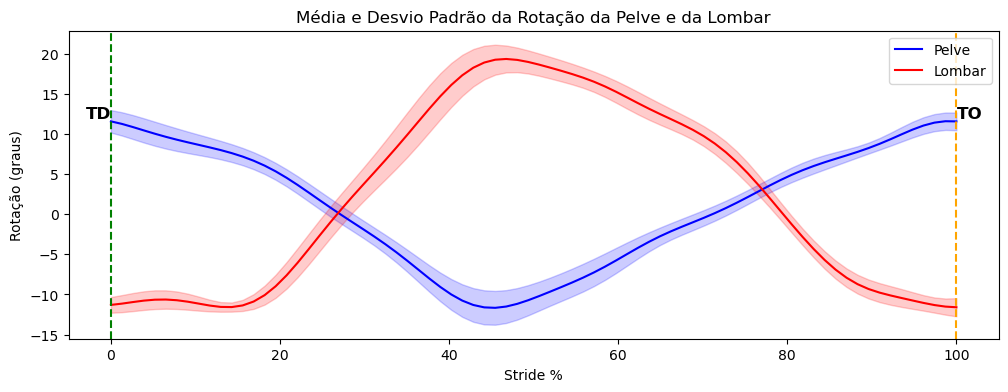

In [35]:
# Vamos primeiro encontrar o comprimento máximo de todos os arrays
max_length = max(len(arr) for arr in Pelvis_Rotation_All_Strides + Lumbar_Rotation_All_Strides)

# Agora vamos interpolar cada array para ter o mesmo comprimento que o máximo encontrado
interp_pelvis_rotation = [interp1d(np.linspace(0, 100, len(arr)), arr)(np.linspace(0, 100, max_length)) for arr in Pelvis_Rotation_All_Strides]
interp_lumbar_rotation = [interp1d(np.linspace(0, 100, len(arr)), arr)(np.linspace(0, 100, max_length)) for arr in Lumbar_Rotation_All_Strides]

# Agora podemos calcular a média e o desvio padrão
mean_pelvis_rotation = np.mean(interp_pelvis_rotation, axis=0)
std_pelvis_rotation = np.std(interp_pelvis_rotation, axis=0)

mean_lumbar_rotation = np.mean(interp_lumbar_rotation, axis=0)
std_lumbar_rotation = np.std(interp_lumbar_rotation, axis=0)

# Definir o tamanho da figura
fig, axs = plt.subplots(1, figsize=(12, 4))  # Largura: 12 polegadas, Altura: 4 polegadas

# Plotar a média da rotação da pelve
axs.plot(np.linspace(0, 100, max_length), mean_pelvis_rotation, label='Pelve', color='blue')

# Plotar o desvio padrão da rotação da pelve
axs.fill_between(np.linspace(0, 100, max_length), mean_pelvis_rotation - std_pelvis_rotation, mean_pelvis_rotation + std_pelvis_rotation, color='blue', alpha=0.2)

# Plotar a média da rotação da lombar
axs.plot(np.linspace(0, 100, max_length), mean_lumbar_rotation, label='Lombar', color='red')

# Plotar o desvio padrão da rotação da lombar
axs.fill_between(np.linspace(0, 100, max_length), mean_lumbar_rotation - std_lumbar_rotation, mean_lumbar_rotation + std_lumbar_rotation, color='red', alpha=0.2)

# Adicionar linhas verticais
axs.axvline(x=0, linestyle='--', color='green')
axs.axvline(x=100, linestyle='--', color='orange')

# Adicionar legendas para as linhas verticais
axs.text(0, mean_pelvis_rotation[0], 'TD', ha='right', va='bottom', fontsize=12, weight='bold')
axs.text(100, mean_pelvis_rotation[-1], 'TO', ha='left', va='bottom', fontsize=12, weight='bold')

axs.set_title('Média e Desvio Padrão da Rotação da Pelve e da Lombar')  # Definir um título geral para os dados
axs.set_xlabel('Stride %')  # Adicionar legenda no eixo X
axs.set_ylabel('Rotação (graus)')  # Adicionar legenda no eixo Y
axs.legend(loc='upper right')  # Adicionar legenda ao lado das curvas
plt.show()


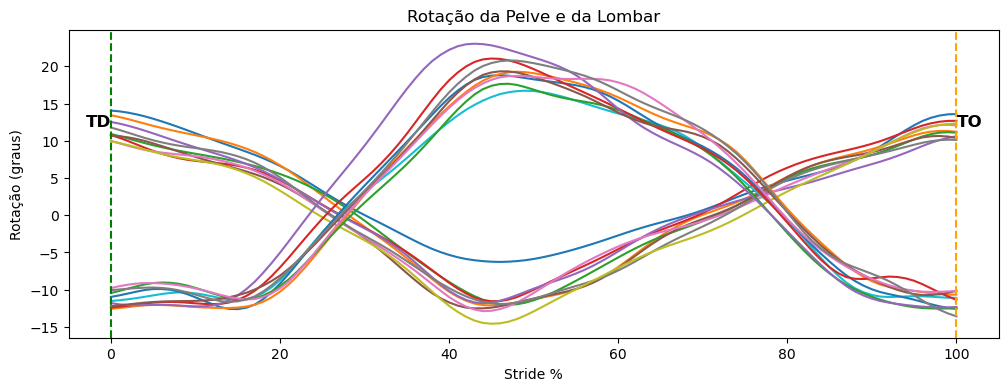

In [36]:
Pelvis_Rotation_All_Strides = []  # Inicialize a lista fora do loop

for k in range(0,len(TD_R)-1):
    start = TD_R[k]
    end = TD_R[k+1]
    Pelvis_Rotation_Stride = Pelvis_Rotation[start:end]
    Pelvis_Rotation_All_Strides.append(Pelvis_Rotation_Stride)
    
Lumbar_Rotation_All_Strides = []  # Inicialize a lista fora do loop

for k in range(0,len(TD_R)-1):
    start = TD_R[k]
    end = TD_R[k+1]
    Lumbar_Rotation_Stride = Lumbar_Rotation[start:end]
    Lumbar_Rotation_All_Strides.append(Lumbar_Rotation_Stride)
# Criar uma escala de 0 a 100 representando 0% a 100% da passada
time_scale = np.linspace(0, 100, 101)

# Definir o tamanho da figura
fig, axs = plt.subplots(1, figsize=(12, 4))  # Largura: 12 polegadas, Altura: 4 polegadas

## Plotar a rotação da pelve interpolada
for pelvis_data in Pelvis_Rotation_All_Strides:
    pelvis_interpolated = np.interp(time_scale, np.linspace(0, 100, len(pelvis_data)), pelvis_data)
    axs.plot(time_scale, pelvis_interpolated, label='Pelve')

# Plotar a rotação da lombar interpolada
for lumbar_data in Lumbar_Rotation_All_Strides:
    lumbar_interpolated = np.interp(time_scale, np.linspace(0, 100, len(lumbar_data)), lumbar_data)
    axs.plot(time_scale, lumbar_interpolated, label='Lombar')

# Adicionar linhas verticais
axs.axvline(x=0, linestyle='--', color='green')
axs.axvline(x=100, linestyle='--', color='orange')

# Adicionar legendas para as linhas verticais
axs.text(0, mean_pelvis_rotation[0], 'TD', ha='right', va='bottom', fontsize=12, weight='bold')
axs.text(100, mean_pelvis_rotation[-1], 'TO', ha='left', va='bottom', fontsize=12, weight='bold')

axs.set_title('Rotação da Pelve e da Lombar')  # Definir um título geral para os dados
axs.set_xlabel('Stride %')  # Adicionar legenda no eixo X
axs.set_ylabel('Rotação (graus)')  # Adicionar legenda no eixo Y
plt.show()


In [37]:
# Criar uma escala de 1 a 100 representando 1% a 100% da passada
time_scale = np.linspace(1, 100, 100)

# Criar um dicionário para armazenar os dados de cada passada da pelve
dados_pelve = {'Passada (%)': time_scale}

# Adicionar os dados da pelve interpolada para cada passada
for i, passo in enumerate(Pelvis_Rotation_All_Strides, start=1):
    pelvis_interpolated = np.interp(time_scale, np.linspace(0, 100, len(passo)), passo)
    dados_pelve[f'Passada_{i}'] = pelvis_interpolated

# Criar um DataFrame para os dados da pelve
df_pelve = pd.DataFrame(dados_pelve)

# Criar um dicionário para armazenar os dados de cada passada da lombar
dados_lombar = {'Passada (%)': time_scale}

# Adicionar os dados da lombar interpolada para cada passada
for i, passo in enumerate(Lumbar_Rotation_All_Strides, start=1):
    lumbar_interpolated = np.interp(time_scale, np.linspace(0, 100, len(passo)), passo)
    dados_lombar[f'Passada_{i}'] = lumbar_interpolated

# Criar um DataFrame para os dados da lombar
df_lombar = pd.DataFrame(dados_lombar)

# Salvar os DataFrames em um arquivo Excel
with pd.ExcelWriter(File_Output + Name + '_' + Trial + '_' + 'curve.xlsx') as writer:
    df_pelve.to_excel(writer, sheet_name='Pelve', index=False)
    df_lombar.to_excel(writer, sheet_name='Lombar', index=False)


In [ ]:
# Criar DataFrame com os dados
df_Export_Data = pd.DataFrame({
    'File': [Name + '_' + Trial + '_' + Group],
    'Name': [Name],
    'Trial': [Trial],
    'Group': [Group],
    'Number All Steps R': [Strides_Number_R],
    'Number All Steps L': [Strides_Number_L],
    'Numero de Passadas Selecionadas': [Numero_Passadas],
    'Speed (km/h)': [Walking_Speed_km],
    'Speed (m/s)': [Speed],
    'Step Swing (s)': [Step_Swing_Mean],
    'Stride Time (s)': [Stride_Time_Mean],
    'Contact Time (s)': [Contact_Time_Mean],
    'Contact Phase Relative (%)': [Contact_Phase_Mean],
    'Stride Length (m)': [Stride_Length_Mean],
    'Stride Frequency (Hz)': [Stride_Frequency_Mean],
    'Rotação Máx Lombar Direita (°)': [abs(Lumbar_Rotation_Min_Mean)],
    'Rotação Máx Lombar Esquerda (°)': [abs(Lumbar_Rotation_Max_Mean)],
    'Rotação Lombar ROM (°)': [abs(Lumbar_Rotation_ROM_Mean)],
    'Rotação Máx Pelvis Direita (°)': [abs(Pelvis_Rotation_Min_Mean)],
    'Rotação Máx Pelvis Esquerda (°)': [abs(Pelvis_Rotation_Max_Mean)],
    'Rotação Pelvis ROM (°)': [abs(Pelvis_Rotation_ROM_Mean)],
    'Dissociação Máx Média (°)': [abs(Dissociação)],
    'Diferença Máx Direita (°)': [abs(Diferença_Direita)],
    'Diferença Máx Esquerda (°)': [abs(Diferença_Esquerda)],
    'Knee Angle Max': [Knee_Max_Mean_Average],
    'Knee Angle Min': [Knee_Min_Mean_Average],
    'Knee Angle ROM': [Knee_ROM_Mean_Average],
    'Hip Angle Max': [Hip_Max_Mean_Average],
    'Hip Angle Min': [Hip_Min_Mean_Average],
    'Hip Angle ROM': [Hip_ROM_Mean_Average],
    'Ankle Angle Max': [Ankle_Max_Mean_Average],
    'Ankle Angle Min': [Ankle_Min_Mean_Average],
    'Ankle Angle ROM': [Ankle_ROM_Mean_Average],
    'Phi Mean (°)': [Phi_Mean],
    'Phi SD (°)': [Phi_SD],
})

File_Output_Path_Full = File_Output + Name + '_' + Trial + '_' + 'output.xlsx'

# Salvar o DataFrame como um arquivo Excel
df_Export_Data.to_excel(File_Output_Path_Full, index=False)

print(f'Exportado para {File_Output_Path_Full}')


Exportado para /Users/borba/Desktop/Não sei o nome_4km_output.xlsx
